# Build a fraud detection model on Vertex AI

In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/fraud_detection/fraud-detection-model.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/fraud_detection/fraud-detection-model.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
   <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/fraud_detection/fraud-detection-model.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>
</table>

## Table of contents

* [Overview](#section-1)
* [Dataset](#section-2)
* [Objective](#section-3)
* [Costs](#section-4)
* [Analyze the dataset](#section-5)
* [Fit a random forest model](#section-6)
* [Analyzing results](#section-7)
* [Save the model to a Cloud Storagae path](#section-8)
* [Create a model in Vertex AI](#section-9)
* [Create an Endpoint](#section-10)  
* [What-If Tool ](#section-11)
* [Clean up](#section-12)

## Overview
<a name="section-1"></a>

This tutorial shows you how to build, deploy, and analyze predictions from a simple [random forest](https://en.wikipedia.org/wiki/Random_forest) model using tools like scikit-learn, Vertex AI, and the [What-IF Tool (WIT)](https://cloud.google.com/ai-platform/prediction/docs/using-what-if-tool) on a synthetic fraud transaction dataset to solve a financial fraud detection problem.


## Dataset
<a name="section-2"></a>


The dataset used in this tutorial is publicly available at Kaggle. See [Synthetic Financial Datasets For Fraud Detection](https://www.kaggle.com/ealaxi/paysim1).

## Objective
<a name="section-3"></a>

This tutorial demonstrates data analysis and model-building using a synthetic financial dataset. The model is trained on identifying fraudulent cases among the transactions. Then, the trained model is deployed on a Vertex AI Endpoint and analyzed using the What-If Tool. The steps taken in this tutorial are as follows: 

- Installation of required libraries
- Reading the dataset from a Cloud Storage bucket
- Performing exploratory analysis on the dataset
- Preprocessing the dataset
- Training a random forest model using scikit-learn
- Saving the model to a Cloud Storage bucket
- Creating a Vertex AI model resource and deploying to an endpoint
- Running the What-If Tool on test data
- Un-deploying the model and cleaning up the model resources

## Costs
<a name="section-4"></a>


This tutorial uses billable components of Google Cloud:

* Vertex AI
* Cloud Storage

Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage. 

### Set up your local development environment

**If you are using Colab or Google Cloud Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip3 install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

## Install additional packages

In [1]:
import os

import google.auth

USER_FLAG = ""
# Google Cloud Notebook requires dependencies to be installed with '--user'
if "default" in dir(google.auth):
    USER_FLAG = "--user"

Install the latest version of the Vertex AI client library.

Run the following command in your notebook environment to install the Vertex SDK for Python:

In [3]:
! pip install {USER_FLAG} --upgrade google-cloud-aiplatform

Run the following command in your notebook environment to install witwidget:

In [4]:
! pip install witwidget

  Using cached witwidget-1.8.1-py3-none-any.whl (1.5 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 497.6/497.6 MB 1.8 MB/s eta 0:00:0000:0100:01
  Using cached absl_py-1.0.0-py3-none-any.whl (126 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 30.1 MB/s eta 0:00:00:00:0100:01
  Using cached gast-0.5.3-py3-none-any.whl (19 kB)
  Using cached tf_estimator_nightly-2.8.0.dev2021122109-py2.py3-none-any.whl (462 kB)
  Using cached termcolor-1.1.0.tar.gz (3.9 kB)
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 KB 11.7 MB/s eta 0:00:00
  Using cached libclang-13.0.0-py2.py3-none-manylinux1_x86_64.whl (14.5 MB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl (12 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl (57 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.0 MB/s eta 0:00:00
  Using cached opt_einsum-3.3.0-py3-none-any.whl (65 kB)
  Using cached flatbuffers-2.0-py2.py3-none-any.whl (26 kB)
  Using c

Run the following command in your notebook environment to install joblib:

In [5]:
! pip install joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 KB 584.3 kB/s eta 0:00:00a 0:00:01


Run the following command in your notebook environment to install scikit-learn:

In [10]:
! pip install scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.4/26.4 MB 47.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 MB 13.9 MB/s eta 0:00:0000:0100:01


Run the following command in your notebook environment to install fsspec:

In [6]:
! pip install fsspec

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.9/134.9 KB 8.2 MB/s eta 0:00:00


Run the following command in your notebook environment to install gcsfs:

In [7]:
! pip install gcsfs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 31.8 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 KB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 304.5/304.5 KB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.2/156.2 KB 23.8 MB/s eta 0:00:00


### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [11]:
# Automatically restart kernel after installs

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com). {TODO: Update the APIs needed for your tutorial. Edit the API names, and update the link to append the API IDs, separating each one with a comma. For example, container.googleapis.com,cloudbuild.googleapis.com}

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

#### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [2]:
PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  vertex-ai-dev


Otherwise, set your project ID here.

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

In [3]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append it onto the name of resources you create in this tutorial.

In [4]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Authenticate your Google Cloud account

**If you are using Google Cloud Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type "Vertex AI"
into the filter box, and select
   **Vertex AI Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [ ]:
import os
import sys

# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# If on Google Cloud Notebooks, then don't execute this code
if not IS_GOOGLE_CLOUD_NOTEBOOK:
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**


When you create a model in Vertex AI using the Cloud SDK, you give a Cloud Storage path where the trained model is saved. 
In this tutorial, Vertex AI saves the trained model to a Cloud Storage bucket. Using this model artifact, you can then
create Vertex AI model and endpoint resources in order to serve
online predictions.

Set the name of your Cloud Storage bucket below. It must be unique across all
Cloud Storage buckets.

You may also change the `REGION` variable, which is used for operations
throughout the rest of this notebook. Make sure to [choose a region where Vertex AI services are
available](https://cloud.google.com/vertex-ai/docs/general/locations#available_regions). You may
not use a Multi-Regional Storage bucket for training with Vertex AI.

In [5]:
BUCKET_NAME = "[your-bucket-name]"  # @param {type:"string"}
REGION = "[your-region]"  # @param {type:"string"}

In [6]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "-vertex-ai-" + TIMESTAMP
BUCKET_URI = f"gs://{BUCKET_NAME}"
if REGION == "[your-region]":
    REGION = "us-central1"

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [7]:
! gsutil mb -l $REGION $BUCKET_URI

Creating gs://vertex-ai-dev-vertex-ai-20220307085736/...


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [8]:
! gsutil ls -al $BUCKET_URI

## Tutorial

### Import required libraries

In [9]:
import warnings

import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from google.cloud import aiplatform, storage
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (average_precision_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from witwidget.notebook.visualization import WitConfigBuilder, WitWidget

warnings.filterwarnings("ignore")

2022-03-07 08:57:56.408009: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-07 08:57:56.408057: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
# Load dataset
df = pd.read_csv(
    "gs://cloud-samples-data/vertex-ai/managed_notebooks/fraud_detection/fraud_detection_data.csv"
)

## Analyze the dataset
<a name="section-5"></a>


Take a quick look at the dataset and the number of rows.

In [11]:
print("shape : ", df.shape)
df.head()

shape :  (6362620, 11)


,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


Check for null values.

In [12]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

Check the type of transactions involved.

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


Text(0, 0.5, 'Amount')

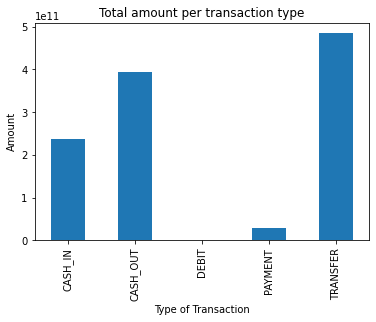

In [13]:
print(df.type.value_counts())
var = df.groupby("type").amount.sum()
fig = plt.figure()
ax1 = fig.add_subplot(1, 1, 1)
var.plot(kind="bar")
ax1.set_title("Total amount per transaction type")
ax1.set_xlabel("Type of Transaction")
ax1.set_ylabel("Amount")

## Working with imbalanced data

Althuogh the outcome variable "isFraud" seems to be very imbalanced in the current dataset, a base model can be trained on it to check the quality of fraudulent transactions in the data and if needed, counter measures like undersampling of majority class or oversampling of the minority class can be considered.

In [14]:
# Count number of fraudulent/non-fraudulent transactions
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

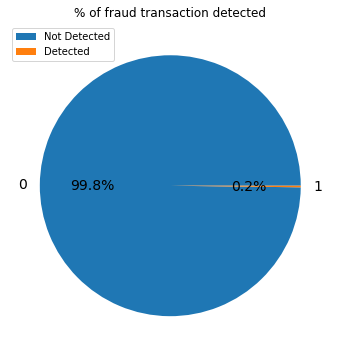

In [15]:
piedata = df.groupby(["isFlaggedFraud"]).sum()
f, axes = plt.subplots(1, 1, figsize=(6, 6))
axes.set_title("% of fraud transaction detected")
piedata.plot(
    kind="pie", y="isFraud", ax=axes, fontsize=14, shadow=False, autopct="%1.1f%%"
)
axes.set_ylabel("")
plt.legend(loc="upper left", labels=["Not Detected", "Detected"])
plt.show()

## Prepare data for modeling
To prepare the dataset for training, a few columns need to be dropped that contain either unique data ('nameOrig','nameDest') or redundant fields ('isFlaggedFraud'). The categorical field "type" which describes the type of transaction and is important for fraud detection needs to be one-hot encoded.


In [16]:
df.drop(["nameOrig", "nameDest", "isFlaggedFraud"], axis=1, inplace=True)

In [17]:
X = pd.concat([df.drop("type", axis=1), pd.get_dummies(df["type"])], axis=1)
X.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,0,0,1,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,0,0,1,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,0,0,1
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,1,0,0,0
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,0,0,1,0


Remove the outcome variable from the training data.

In [18]:
y = X[["isFraud"]]
X = X.drop(["isFraud"], axis=1)

Split the data and assign 70% for training and 30% for testing.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, shuffle=False
)
print(X_train.shape, X_test.shape)

(4453834, 11) (1908786, 11)


## Fit a random forest model
<a name="section-6"></a>

Fit a simple random forest classifier on the preprocessed training dataset.

In [20]:
%%time
forest = RandomForestClassifier()
forest.fit(X_train, y_train)

CPU times: user 12min 16s, sys: 11.4 s, total: 12min 27s
Wall time: 12min 28s


RandomForestClassifier()

## Analyzing Results
<a name="section-7"></a>

The model returns good scores and the confusion matrix confirms that this model can indeed work with imbalanced data.

In [21]:
y_prob = forest.predict_proba(X_test)
y_pred = forest.predict(X_test)

print("AUPRC :", (average_precision_score(y_test, y_prob[:, 1])))
print("F1 - score :", (f1_score(y_test, y_pred)))

print("Confusion_matrix : ")
print(confusion_matrix(y_test, y_pred))

print("classification_report")
print(classification_report(y_test, y_pred))

AUPRC : 0.9266427037314564
F1 - score : 0.8494866015527173
Confusion_matrix : 
[[1904192      24]
 [   1178    3392]]
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1904216
           1       0.99      0.74      0.85      4570

    accuracy                           1.00   1908786
   macro avg       1.00      0.87      0.92   1908786
weighted avg       1.00      1.00      1.00   1908786



Use `RandomForestClassifier`'s `feature_importances_ function` to get a better understanding about which features were the most useful to the model.

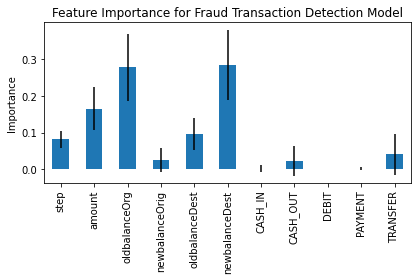

In [22]:
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
forest_importances = pd.Series(importances, index=list(X_train))
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature Importance for Fraud Transaction Detection Model")
ax.set_ylabel("Importance")
fig.tight_layout()

## Save the model to a Cloud Storage path
<a name="section-8"></a>

In [23]:
# save the trained model to a local file "model.joblib"
FILE_NAME = "model.joblib"
joblib.dump(forest, FILE_NAME)

# Upload the saved model file to Cloud Storage
BLOB_PATH = "[your-blob-path]"
BLOB_NAME = os.path.join(BLOB_PATH, FILE_NAME)

bucket = storage.Client(PROJECT_ID).bucket(BUCKET_NAME)
blob = bucket.blob(BLOB_NAME)
blob.upload_from_filename(FILE_NAME)

## Create a model in Vertex AI
<a name="section-9"></a>

In [24]:
MODEL_DISPLAY_NAME = "[your-model-display-name]"
ARTIFACT_GCS_PATH = f"{BUCKET_URI}/{BLOB_PATH}"
SERVING_CONTAINER_IMAGE_URI="us-docker.pkg.dev/vertex-ai/prediction/sklearn-cpu.1-0:latest"

In [25]:
# Create a Vertex AI model resource

aiplatform.init(project=PROJECT_ID, location=REGION)

model = aiplatform.Model.upload(
    display_name=MODEL_DISPLAY_NAME,
    artifact_uri=ARTIFACT_GCS_PATH,
    serving_container_image_uri=SERVING_CONTAINER_IMAGE_URI,
)

model.wait()

print(model.display_name)
print(model.resource_name)

INFO:google.cloud.aiplatform.models:Creating Model
INFO:google.cloud.aiplatform.models:Create Model backing LRO: projects/931647533046/locations/us-central1/models/3919789739347017728/operations/5607496725993357312
INFO:google.cloud.aiplatform.models:Model created. Resource name: projects/931647533046/locations/us-central1/models/3919789739347017728
INFO:google.cloud.aiplatform.models:To use this Model in another session:
INFO:google.cloud.aiplatform.models:model = aiplatform.Model('projects/931647533046/locations/us-central1/models/3919789739347017728')
[your-model-display-name]
projects/931647533046/locations/us-central1/models/3919789739347017728


## Create an Endpoint
<a name="section-10"></a>

In [26]:
ENDPOINT_DISPLAY_NAME = "[your-endpoint-display-name]"

In [27]:
endpoint = aiplatform.Endpoint.create(display_name=ENDPOINT_DISPLAY_NAME)


print(endpoint.display_name)
print(endpoint.resource_name)

INFO:google.cloud.aiplatform.models:Creating Endpoint
INFO:google.cloud.aiplatform.models:Create Endpoint backing LRO: projects/931647533046/locations/us-central1/endpoints/1055856618106781696/operations/3761020878771453952
INFO:google.cloud.aiplatform.models:Endpoint created. Resource name: projects/931647533046/locations/us-central1/endpoints/1055856618106781696
INFO:google.cloud.aiplatform.models:To use this Endpoint in another session:
INFO:google.cloud.aiplatform.models:endpoint = aiplatform.Endpoint('projects/931647533046/locations/us-central1/endpoints/1055856618106781696')
[your-endpoint-display-name]
projects/931647533046/locations/us-central1/endpoints/1055856618106781696


### Deploy the model to the created Endpoint

Configure the deployment name, machine type, and other parameters for the deployment.

In [28]:
DEPLOYED_MODEL_NAME = "[your-deployed-model-name]"
MACHINE_TYPE = "n1-standard-2"

In [29]:
# deploy the model to the endpoint
model.deploy(
    endpoint=endpoint,
    deployed_model_display_name=DEPLOYED_MODEL_NAME,
    machine_type=MACHINE_TYPE,
)

model.wait()

print(model.display_name)
print(model.resource_name)

INFO:google.cloud.aiplatform.models:Deploying model to Endpoint : projects/931647533046/locations/us-central1/endpoints/1055856618106781696
INFO:google.cloud.aiplatform.models:Deploy Endpoint model backing LRO: projects/931647533046/locations/us-central1/endpoints/1055856618106781696/operations/8372706897198841856
INFO:google.cloud.aiplatform.models:Endpoint model deployed. Resource name: projects/931647533046/locations/us-central1/endpoints/1055856618106781696
[your-model-display-name]
projects/931647533046/locations/us-central1/models/3919789739347017728


Save the ID of the deployed model. The ID of the deployed model can also be checked by using the `endpoint.list_models()` method.

## What-If Tool 
<a name="section-11"></a>

The What-If Tool can be used to analyze the model predictions on a test data. See a [brief introduction to the What-If Tool](https://pair-code.github.io/what-if-tool/). In this tutorial, the What-If Tool will be configured and run on the model trained locally, and on the model deployed on Vertex AI Endpoint in the previous steps.

[WitConfigBuilder](https://github.com/PAIR-code/what-if-tool/blob/master/witwidget/notebook/visualization.py#L30) provides the  `set_ai_platform_model()` method to configure the What-If Tool with a model deployed as a version on Ai Platform models. This feature currently supports Ai Platform only but not Vertex AI models. Fortunately, there is also an option to pass a custom function for generating predictions through the `set_custom_predict_fn()` method where either the locally trained model or a function that returns predictions from a Vertex AI model can be passed.

### Prepare test samples

Save some samples from the test data for both the available classes (Fraud/not-Fraud) to analyze the model using the What-If Tool.

In [30]:
# collect 50 samples for each class-label from the test data
pos_samples = y_test[y_test["isFraud"] == 1].sample(50).index
neg_samples = y_test[y_test["isFraud"] == 0].sample(50).index
test_samples_y = pd.concat([y_test.loc[pos_samples], y_test.loc[neg_samples]])
test_samples_X = X_test.loc[test_samples_y.index].copy()

### Running the What-If Tool on the local model

In [31]:
# define target and labels
TARGET_FEATURE = "isFraud"
LABEL_VOCAB = ["not-fraud", "fraud"]

# define the function to adjust the predictions


def adjust_prediction(pred):
    return [1 - pred, pred]


# Combine the features and labels into one array for the What-If Tool
test_examples = np.hstack(
    (test_samples_X.to_numpy(), test_samples_y.to_numpy().reshape(-1, 1))
)

# Configure the WIT to run on the locally trained model
config_builder = (
    WitConfigBuilder(
        test_examples.tolist(), test_samples_X.columns.tolist() + ["isFraud"]
    )
    .set_custom_predict_fn(forest.predict_proba)
    .set_target_feature(TARGET_FEATURE)
    .set_label_vocab(LABEL_VOCAB)
)

# display the WIT widget
WitWidget(config_builder, height=600)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['not-fraud', 'fraud'], 'feature_names': ['st…

### Running the What-If Tool on the deployed Vertex AI model

In [32]:
# configure the target and class-labels
TARGET_FEATURE = "isFraud"
LABEL_VOCAB = ["not-fraud", "fraud"]

# function to return predictions from the deployed Model


def endpoint_predict_sample(instances: list):
    prediction = endpoint.predict(instances=instances)
    preds = [[1 - i, i] for i in prediction.predictions]
    return preds


# Combine the features and labels into one array for the What-If Tool
test_examples = np.hstack(
    (test_samples_X.to_numpy(), test_samples_y.to_numpy().reshape(-1, 1))
)

# Configure the WIT with the prediction function
config_builder = (
    WitConfigBuilder(
        test_examples.tolist(), test_samples_X.columns.tolist() + ["isFraud"]
    )
    .set_custom_predict_fn(endpoint_predict_sample)
    .set_target_feature(TARGET_FEATURE)
    .set_label_vocab(LABEL_VOCAB)
)

# run the WIT-widget
WitWidget(config_builder, height=400)

WitWidget(config={'model_type': 'classification', 'label_vocab': ['not-fraud', 'fraud'], 'feature_names': ['st…

## Undeploy the model
When you are done doing predictions, you undeploy the model from the Endpoint resouce. This deprovisions all compute resources and ends billing for the deployed model.

In [33]:
endpoint.undeploy_all()

INFO:google.cloud.aiplatform.models:Undeploying Endpoint model: projects/931647533046/locations/us-central1/endpoints/1055856618106781696
INFO:google.cloud.aiplatform.models:Undeploy Endpoint model backing LRO: projects/931647533046/locations/us-central1/endpoints/1055856618106781696/operations/7192763794827771904
INFO:google.cloud.aiplatform.models:Endpoint model undeployed. Resource name: projects/931647533046/locations/us-central1/endpoints/1055856618106781696


resource name: projects/931647533046/locations/us-central1/endpoints/1055856618106781696

## Clean up
<a name="section-12"></a>


To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial:

In [34]:
# delete the endpoint
endpoint.delete()

INFO:google.cloud.aiplatform.base:Deleting Endpoint : projects/931647533046/locations/us-central1/endpoints/1055856618106781696
INFO:google.cloud.aiplatform.base:Delete Endpoint  backing LRO: projects/931647533046/locations/us-central1/operations/3378214910444961792
INFO:google.cloud.aiplatform.base:Endpoint deleted. . Resource name: projects/931647533046/locations/us-central1/endpoints/1055856618106781696


In [35]:
# delete the model
model.delete()

INFO:google.cloud.aiplatform.base:Deleting Model : projects/931647533046/locations/us-central1/models/3919789739347017728
INFO:google.cloud.aiplatform.base:Delete Model  backing LRO: projects/931647533046/locations/us-central1/operations/2364904994286600192
INFO:google.cloud.aiplatform.base:Model deleted. . Resource name: projects/931647533046/locations/us-central1/models/3919789739347017728


In [37]:
if os.getenv("IS_TESTING"):
    ! gsutil -m rm -r $BUCKET_URI

E0307 09:40:07.049575696   19698 fork_posix.cc:70]           Fork support is only compatible with the epoll1 and poll polling strategies


Removing gs://vertex-ai-dev-vertex-ai-20220307085736/...
ServiceException: 409 A Cloud Storage bucket named 'vertex-ai-dev-vertex-ai-20220307085736' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.
